# Traditional Methods for ML on Graphs

In this lab, we will explore graph features. Graph features are quantitative measurements that can be used to describe the structure and properties of a graph. They can be used for a variety of tasks, such as clustering, classification, and link prediction.

We will start by exploring nodal degree. Node degree is the number of neighbors that a node has. We will then move on to explore various centrality measures. Centrality measures quantify the importance of nodes in a graph. Some common centrality measures include degree centrality, closeness centrality, and betweenness centrality.

Finally, we will explore some common graph kernels, that can be used to learn from graphs. They work by transforming graphs into vectors, which can then be used by machine learning algorithms.

In [13]:
!python --version

Python 3.9.19


In [14]:
# !wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh
# !chmod +x mini.sha
# !bash ./mini.sh -b -f -p /usr/local
# !conda install -q -y jupyter
# !conda install -q -y google-colab -c conda-forge
# !python -m ipykernel install --name "py38" --user

In [15]:
!python --version

Python 3.9.19


In [16]:
try:
    # Check if GraKeL is installed:
    import grakel
except ImportError:
    # If GraKeL is not installed, install it.
    %pip install grakel==0.1.8
    # !pip install grakel

# #https://ysig.github.io/GraKeL/0.1a8/index.html

In [17]:
import itertools
import random
import time
from collections import defaultdict
from typing import Callable, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [18]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

Let's write a function that will create a plot of the graph, with the node size proportional to the degree centrality of each node

In [19]:
def features_example(
    feature_extraction_fun: Callable[[nx.Graph], Dict[Union[str, Tuple[str, str]], Union[int, float]]],
    fig_size: Tuple[int, int] = (6, 3),
    node_color: str = "tab:orange",
    node_size: int = 1500,
    width: int = 2,
    seed: Optional[int] = None,
) -> None:
    edge_list = [("A", "C"), ("B", "C"), ("B", "D"), ("C", "D"), ("D", "E"), ("D", "H"), ("E", "F"), ("E", "G")]
    G = nx.Graph(edge_list)
    name = feature_extraction_fun.__name__.replace("_", " ").capitalize()
    features = feature_extraction_fun(G)
    pos = nx.spring_layout(G, seed=seed)

    plt.figure(figsize=fig_size)
    nx.draw(G, pos=pos, node_color=node_color, node_size=node_size, width=width, with_labels=True)
    plt.show()

    print(f"\n{name} values:")
    for key, value in sorted(features.items(), key=lambda item: item[0]):
        print(f"- {key}: {value:.2f}")

# Node Features: Node Degree

\begin{equation}
    \text{degree}(i) = \sum_{j=1}^{n} a_{ij}
\end{equation}

In [20]:
def node_degree(G: nx.Graph) -> Dict[str, int]:
    return dict(G.degree)

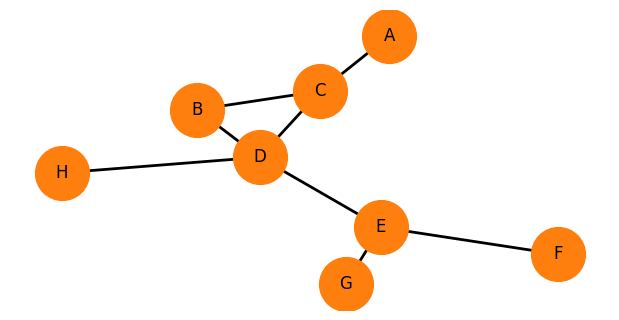


Node degree values:
- A: 1.00
- B: 2.00
- C: 3.00
- D: 4.00
- E: 3.00
- F: 1.00
- G: 1.00
- H: 1.00


In [21]:
features_example(node_degree, seed=42)

In many instances the degree is scaled or normalized, which is commonly referred to as the **degree centrality**

\begin{equation}
    C_{D}(i) = \frac{1}{n-1} \sum_{j=1}^{n} a_{ij}
\end{equation}

In [22]:
def degree_centrality(G: nx.Graph) -> Dict[str, int]:
    return dict(nx.degree_centrality(G))

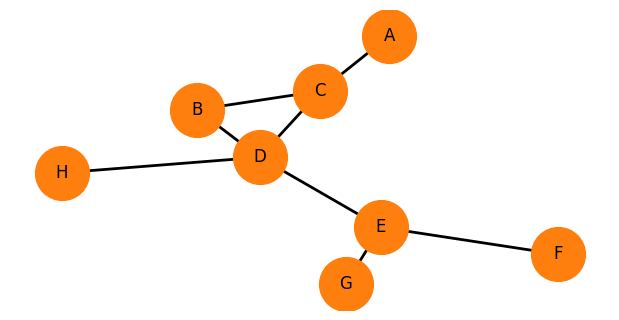


Degree centrality values:
- A: 0.14
- B: 0.29
- C: 0.43
- D: 0.57
- E: 0.43
- F: 0.14
- G: 0.14
- H: 0.14


In [23]:
features_example(degree_centrality, seed=42)

# Node Centrality (1)

## Eigenvector centrality

The eigenvector centrality concept relies on the **Perron-Frobenius Theorem**, a very important result from linear algebra.

Let $G$ be a connected, undirected, and aperiodic graph. Then the adjacency matrix $A$ of $G$ is diagonalizable with eigenvalues

$$
\lambda_{1} \geq \lambda_{2} \geq \ldots \geq \lambda_{n}
$$

with corresponding orthonormal vectors $u_{1}, u_{2}, \ldots, u_{n}$. Furthermore...


*   The eigenvalue $\lambda_{1}$ has multiplicity one, and $\lambda_{1} > \left\vert \lambda_{i} \right\vert$ for $2 \leq i \leq n$
*   The corresponding eigenvector $u_{1}$ has non-negative entries





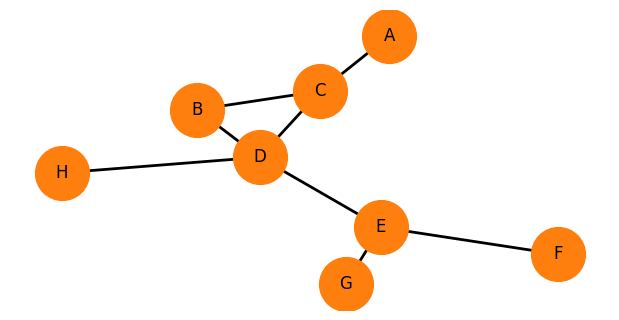


Eigenvector centrality values:
- A: 0.19
- B: 0.42
- C: 0.48
- D: 0.59
- E: 0.34
- F: 0.14
- G: 0.14
- H: 0.23


In [24]:
features_example(nx.eigenvector_centrality, seed=42)

In [25]:
edge_list_G = [("A", "C"), ("B", "C"), ("B", "D"), ("C", "D"), ("D", "E"), ("D", "H"), ("E", "F"), ("E", "G")]
G = nx.Graph(edge_list_G)
eva, eve = np.linalg.eig(nx.adjacency_matrix(G).todense())
first_eve = np.abs(eve[:, 0])
dict(zip(G.nodes, first_eve))

{'A': 0.19028140359241275,
 'C': 0.4783935037374381,
 'B': 0.4242460964454845,
 'D': 0.588219274462496,
 'E': 0.3422595074369788,
 'H': 0.23396469285307184,
 'F': 0.1361339963004594,
 'G': 0.1361339963004594}

This measure rewards **high degree** and **proximity** to important vertices.  

So... what would happen to two almost identical graphs?

In [26]:
edge_list = [
    (1, 2),
    (2, 3),
    (2, 4),
    (4, 5),
    (4, 6),
    (5, 6),
    (6, 3)
]
edge_list_cut = [
    (2, 3),
    (2, 4),
    (4, 5),
    (4, 6),
    (5, 6),
    (6, 3)
]
H = nx.Graph(edge_list)
H_cut = nx.Graph(edge_list_cut)

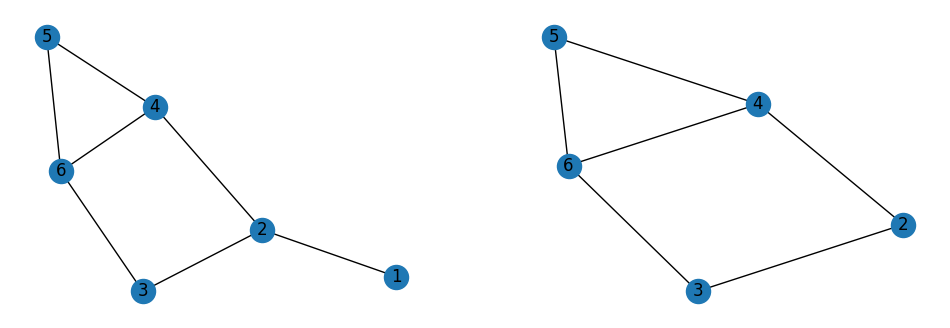

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].set_axis_off()
ax[0] = fig.add_subplot(1, 2, 1)
nx.draw(H, with_labels=True, ax=ax[0])
ax[1].set_axis_off()
ax[1] = fig.add_subplot(1, 2, 2)
nx.draw(H_cut, with_labels=True, ax=ax[1])

plt.show()

In [28]:
H_matrix = nx.adjacency_matrix(H).todense()
H_matrix_cut = nx.adjacency_matrix(H_cut).todense()
print(H_matrix, end="\n\n")
print(H_matrix_cut)

[[0 1 0 0 0 0]
 [1 0 1 1 0 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 1 1 1 0]]

[[0 1 1 0 0]
 [1 0 0 0 1]
 [1 0 0 1 1]
 [0 0 1 0 1]
 [0 1 1 1 0]]


Now compare the eigenvector centrality of both graphs

In [29]:
evalues, evectors = np.linalg.eig(H_matrix)
evalues_cut, evectors_cut = np.linalg.eig(H_matrix_cut)
first_evector = np.abs(evectors[:, 0])
first_evector_cut = np.abs(evectors[:, 0])

In [30]:
print(nx.eigenvector_centrality(H))

print(nx.eigenvector_centrality(H_cut))

{1: 0.16050115266283901, 2: 0.4075878178953184, 3: 0.35830784164631824, 4: 0.516251205914231, 5: 0.4010962801512062, 6: 0.5023280877603375}
{2: 0.35775191431708964, 3: 0.35775191431708964, 4: 0.529898889076173, 5: 0.4271316779596083, 6: 0.5298988890761731}


The eigenvector centrality $c_{i}^{E}$ of a vertex $i$ is the entry $v_{i}$, where $v$ has been scaled and where $v$ is the eigenvector associated to the largest eigenvalue $\lambda$ of $A$

\begin{equation}
    Av = \lambda v
\end{equation}

# Node Centrality (2)

## Betweenness centrality

The betweenness centrality of a node $k$ is the sum of the fractions of all-pairs shortests paths that pass through $k$

\begin{equation}
    C_{B}(k) = \sum_{i,j \in V(G) }^{n} \frac{ \sigma_{ij}(k) }{\sigma_{ij}}
\end{equation}

where

*   $\sigma_{ij}$ is the number of shortest $(i,j)$-paths
*   $\sigma_{ij}(k)$ is the number of those paths passing through some node $k$ other than $i,j$



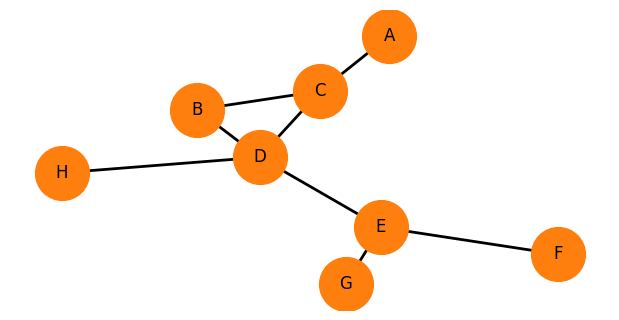


Betweenness centrality values:
- A: 0.00
- B: 0.00
- C: 0.29
- D: 0.71
- E: 0.52
- F: 0.00
- G: 0.00
- H: 0.00


In [31]:
features_example(nx.betweenness_centrality, seed=42)

In [32]:
counter = 0
print("Pair \t", "Path with D")
for sorce_node, path_collection in nx.shortest_path(G).items():
    for destination_node, path in path_collection.items():
        for node in path[1:-1]:
            if node == "D":
                print(f"({path[0]}, {path[-1]}) \t", "".join(path))
                counter += 1
print(counter)

Pair 	 Path with D
(A, E) 	 ACDE
(A, H) 	 ACDH
(A, F) 	 ACDEF
(A, G) 	 ACDEG
(C, E) 	 CDE
(C, H) 	 CDH
(C, F) 	 CDEF
(C, G) 	 CDEG
(B, E) 	 BDE
(B, H) 	 BDH
(B, F) 	 BDEF
(B, G) 	 BDEG
(E, B) 	 EDB
(E, C) 	 EDC
(E, H) 	 EDH
(E, A) 	 EDCA
(H, B) 	 HDB
(H, C) 	 HDC
(H, E) 	 HDE
(H, A) 	 HDCA
(H, F) 	 HDEF
(H, G) 	 HDEG
(F, B) 	 FEDB
(F, C) 	 FEDC
(F, H) 	 FEDH
(F, A) 	 FEDCA
(G, B) 	 GEDB
(G, C) 	 GEDC
(G, H) 	 GEDH
(G, A) 	 GEDCA
30


In [33]:
n = len(G)
normalizator = (n-1)*(n-2)
betweenness = dict(zip(G.nodes, [0 for _ in range(n)]))

all_paths = nx.shortest_path(G)
for source_node, path_collection in all_paths.items():
    for target_node, path in path_collection.items():
        for node in path[1:-1]:  # exclude the initial and final nodes
            betweenness[node] += 1 / normalizator

betweenness

{'A': 0,
 'C': 0.2857142857142857,
 'B': 0,
 'D': 0.7142857142857147,
 'E': 0.5238095238095241,
 'H': 0,
 'F': 0,
 'G': 0}

In [34]:
#

# Node Centrality (3)

## Closeness centrality

\begin{equation}
    C_{C}(i) = \frac{n-1}{\sum_{j=1}^{n} d(i,j)}
\end{equation}

Consider the clossness centrality of nodes $F$ and $D$:

\begin{equation}
    C_{C}(D) = \frac{7}{2 + 1 + 1 + 0 + 1 + 2 + 2 + 1} = \frac{7}{10}
\end{equation}

\begin{equation}
    C_{C}(F) = \frac{7}{4 + 3 + 3 + 2 + 1 + 0 + 2 + 3} = \frac{7}{18}
\end{equation}


In [35]:
print("C(D)= {}, C(F) = {}".format(7/10, 7/18))

C(D)= 0.7, C(F) = 0.3888888888888889


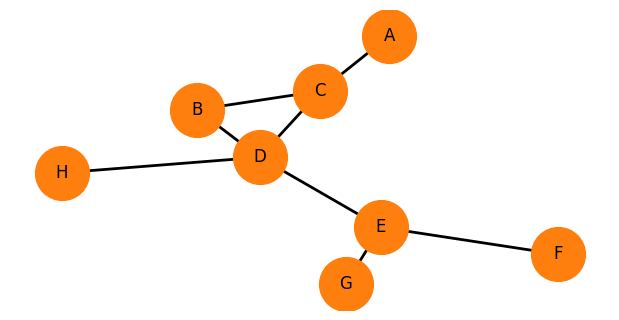


Closeness centrality values:
- A: 0.37
- B: 0.50
- C: 0.54
- D: 0.70
- E: 0.58
- F: 0.39
- G: 0.39
- H: 0.44


In [36]:
features_example(nx.closeness_centrality, seed=42)

# Node Features: Clustering Coefficient

\begin{equation}
    \text{clustering coefficient}(u) = \frac{2T(u)}{\text{deg}(u)(\text{deg}(u)-1)}
\end{equation}

where $T(u)$ is the number of triangles through node $u$

In [37]:
nx.triangles(G, nodes="D")

1

\begin{equation}
    \text{clustering coefficient}(D)
    =
    \frac{2T(u)}{\text{deg}(u)(\text{deg}(u)-1)}
    =
    \frac{2\cdot 1}{4 \cdot 3} = \frac{1}{6}
\end{equation}

In [38]:
1/6

0.16666666666666666

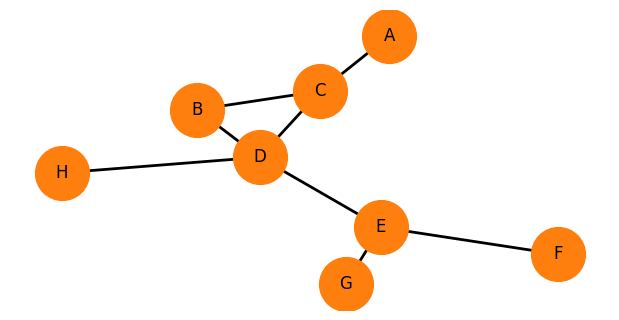


Clustering values:
- A: 0.00
- B: 1.00
- C: 0.33
- D: 0.17
- E: 0.00
- F: 0.00
- G: 0.00
- H: 0.00


In [39]:
features_example(nx.clustering, seed=42)

Note: For directed graphs this is the same, we just consider directed graphs directions.

# Node Features: Graphlets

In [40]:
def plot_graph(
    G: nx.Graph,
    root: str,
    graphlet_nodes: set = set(),
    node_size: int = 1000,
    width: int = 2,
    seed: Optional[int] = None,
) -> None:
    colors = {node: "tab:gray" for node in graphlet_nodes}
    colors[root] = "tab:red"
    node_color = [colors.get(node, "white") for node in G.nodes()]
    edgecolors = ["none" if node == root else "black" for node in G.nodes()]
    labels = {node: node if node == root else "" for node in G.nodes()}
    pos = nx.spring_layout(G, seed=seed)
    nx.draw(G, pos=pos, node_color=node_color, edgecolors=edgecolors, labels=labels, node_size=node_size, width=width)


def add_is_root_attr(G: nx.Graph, root: str) -> nx.Graph:
    is_root = {node: {"is_root": node == root} for node in G.nodes}
    nx.set_node_attributes(G, is_root)

## Possibile graphlets up to size 3

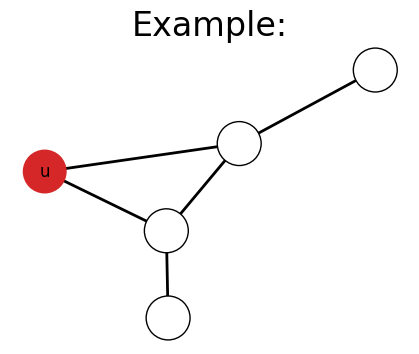

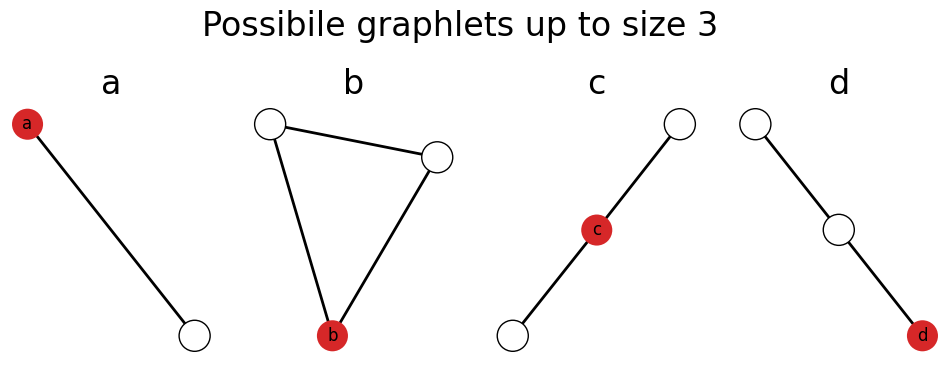

In [41]:
edge_list = [("u", "B"), ("u", "C"), ("B", "C"), ("B", "D"), ("C", "E")]
G = nx.Graph(edge_list)
add_is_root_attr(G, "u")
possible_graphlets_up_to_size_3 = {
    "a": nx.Graph([("a", "B")]),
    "b": nx.Graph([("b", "B"), ("b", "C"), ("B", "C")]),
    "c": nx.Graph([("c", "B"), ("c", "C")]),
    "d": nx.Graph([("B", "d"), ("B", "C")]),
}
for root, possible_graphlet in possible_graphlets_up_to_size_3.items():
    add_is_root_attr(possible_graphlet, root)


plt.figure(figsize=(4, 3))
plot_graph(G, "u")
plt.title("Example:", fontsize=24)
plt.show()

plt.figure(figsize=(12, 4))

for idx, (root, graphlet) in enumerate(possible_graphlets_up_to_size_3.items(), 1):
    plt.subplot(1, 4, idx)
    plt.title(root, fontsize=24)
    plot_graph(graphlet, root, node_size=500)

plt.suptitle("Possibile graphlets up to size 3", fontsize=24)
plt.subplots_adjust(top=0.75)
plt.show()

## Graphlet instances of node u

In [42]:
def _node_match(n1: Dict[str, bool], n2: Dict[str, bool]) -> bool:
    return n1["is_root"] and n2["is_root"] or not n1["is_root"] and not n2["is_root"]


def get_graphlet_instances(
    G: nx.Graph, node: str, possible_graphlets: Dict[str, nx.Graph], max_size: int = 3
) -> Dict[str, List[nx.Graph]]:
    graphlet_instances = defaultdict(list)
    for size in range(2, max_size + 1):
        for combination in itertools.combinations(G.nodes, size):
            if node in combination:
                subgraph = nx.subgraph(G, combination)
                if nx.is_connected(subgraph):
                    for key, graphlet in possible_graphlets.items():
                        if nx.is_isomorphic(subgraph, graphlet, node_match=_node_match):
                            graphlet_instances[key].append(subgraph)
                            break

    return dict(graphlet_instances)

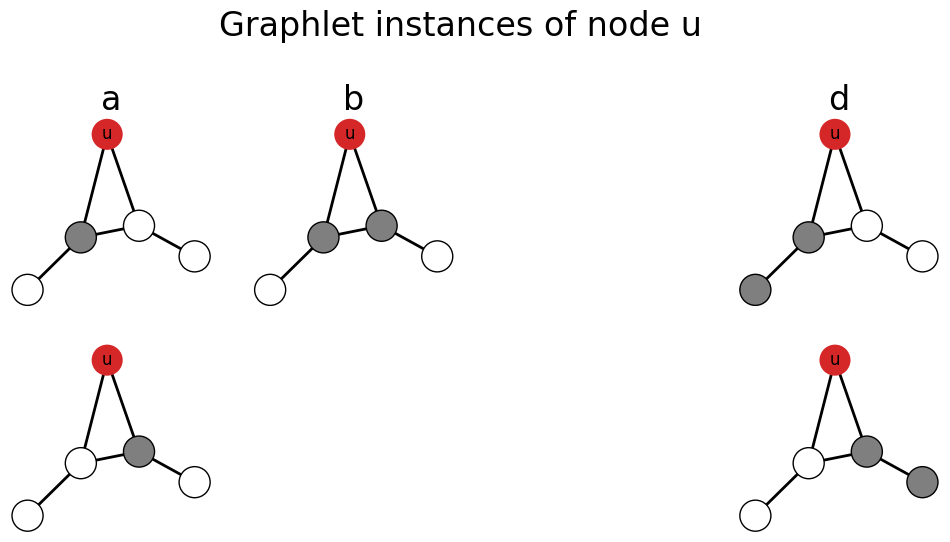

In [43]:
graphlet_instances = get_graphlet_instances(G, "u", possible_graphlets_up_to_size_3)
num_rows = max(len(graphlets) for graphlets in graphlet_instances.values())
num_cols = len(possible_graphlets_up_to_size_3)

plt.figure(figsize=(12, 6))
for col_idx, key in enumerate(sorted(possible_graphlets_up_to_size_3.keys())):
    graphlets = graphlet_instances.get(key, {})
    for row_idx, graphlet in enumerate(graphlets):
        plt.subplot(num_rows, num_cols, row_idx * num_cols + col_idx + 1)
        plot_graph(G, "u", graphlet.nodes, node_size=500, seed=42)
        if row_idx == 0:
            plt.title(key, fontsize=24)

plt.suptitle("Graphlet instances of node u", fontsize=24)
plt.subplots_adjust(top=0.80)
plt.show()

## Graph Degree Vector (GDV) of node u

In [44]:
def get_graph_degree_vector(G: nx.Graph, root: str, possible_graphlets: Dict[str, nx.Graph]) -> List[int]:
    graphlet_instances = get_graphlet_instances(G, "u", possible_graphlets)
    out = []
    for key in sorted(possible_graphlets.keys()):
        out.append(len(graphlet_instances.get(key, [])))

    return out

In [45]:
gdv = get_graph_degree_vector(G, "u", possible_graphlets_up_to_size_3)

print(f"GDV of a node u: {gdv}")

GDV of a node u: [2, 1, 0, 2]


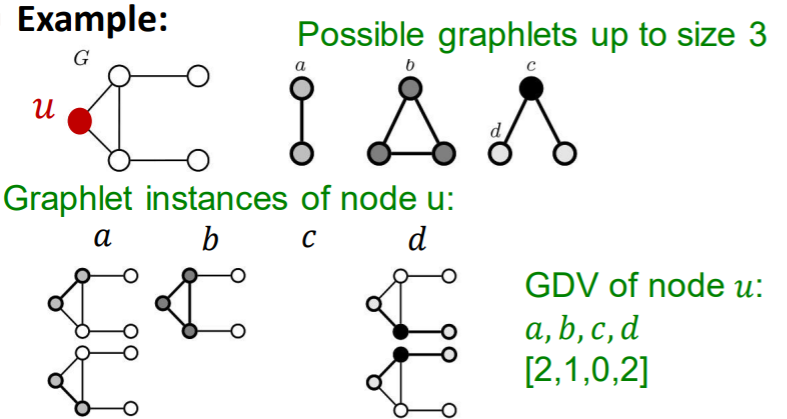

# Link-Level Features: Overview

# Distance-Based Features

## Shortest-path distance between two nodes

In [46]:
def shortest_path_length(G: nx.Graph) -> Dict[Tuple[str, str], int]:
    out = {}
    for node_pair in itertools.combinations(G.nodes, 2):
        out[node_pair] = nx.shortest_path_length(G, *node_pair)

    return out

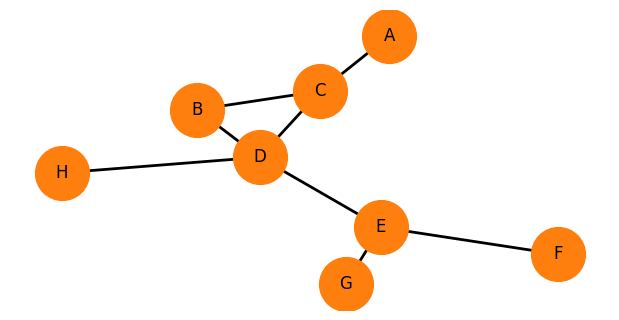


Shortest path length values:
- ('A', 'B'): 2.00
- ('A', 'C'): 1.00
- ('A', 'D'): 2.00
- ('A', 'E'): 3.00
- ('A', 'F'): 4.00
- ('A', 'G'): 4.00
- ('A', 'H'): 3.00
- ('B', 'D'): 1.00
- ('B', 'E'): 2.00
- ('B', 'F'): 3.00
- ('B', 'G'): 3.00
- ('B', 'H'): 2.00
- ('C', 'B'): 1.00
- ('C', 'D'): 1.00
- ('C', 'E'): 2.00
- ('C', 'F'): 3.00
- ('C', 'G'): 3.00
- ('C', 'H'): 2.00
- ('D', 'E'): 1.00
- ('D', 'F'): 2.00
- ('D', 'G'): 2.00
- ('D', 'H'): 1.00
- ('E', 'F'): 1.00
- ('E', 'G'): 1.00
- ('E', 'H'): 2.00
- ('F', 'G'): 2.00
- ('H', 'F'): 3.00
- ('H', 'G'): 3.00


In [47]:
features_example(shortest_path_length, seed=42)

# Local Neighborhood Overlap

## Common neighbors

\begin{equation}
    \text{Common}(u,v)
    =
    \left\lbrace
    \begin{matrix}
    1 \quad \Gamma(u) \cap \Gamma(v) \neq \emptyset \\
    0 \quad \Gamma(u) \cap \Gamma(v) = \emptyset
    \end{matrix}
    \right.
\end{equation}

In [48]:
edge_list_G = [("A", "C"), ("B", "C"), ("B", "D"), ("C", "D"), ("D", "E"), ("D", "H"), ("E", "F"), ("E", "G")]
G = nx.Graph(edge_list_G)

for pair in [("H", "E"), ("A", "C")]:
    source_node, destination_node = pair
    print(source_node, destination_node, list(nx.common_neighbors(G, source_node, destination_node)))

H E ['D']
A C []


In [49]:
def num_common_neighbors(G: nx.Graph) -> Dict[Tuple[str, str], int]:
    return {edge: len(list((nx.common_neighbors(G, *edge)))) for edge in itertools.combinations(G.nodes, 2)}

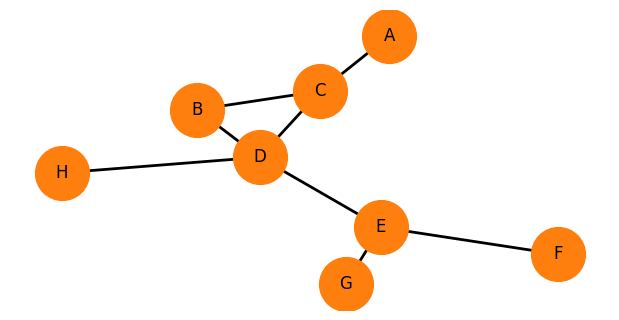


Num common neighbors values:
- ('A', 'B'): 1.00
- ('A', 'C'): 0.00
- ('A', 'D'): 1.00
- ('A', 'E'): 0.00
- ('A', 'F'): 0.00
- ('A', 'G'): 0.00
- ('A', 'H'): 0.00
- ('B', 'D'): 1.00
- ('B', 'E'): 1.00
- ('B', 'F'): 0.00
- ('B', 'G'): 0.00
- ('B', 'H'): 1.00
- ('C', 'B'): 1.00
- ('C', 'D'): 1.00
- ('C', 'E'): 1.00
- ('C', 'F'): 0.00
- ('C', 'G'): 0.00
- ('C', 'H'): 1.00
- ('D', 'E'): 0.00
- ('D', 'F'): 1.00
- ('D', 'G'): 1.00
- ('D', 'H'): 0.00
- ('E', 'F'): 0.00
- ('E', 'G'): 0.00
- ('E', 'H'): 1.00
- ('F', 'G'): 1.00
- ('H', 'F'): 0.00
- ('H', 'G'): 0.00


In [50]:
features_example(num_common_neighbors, seed=42)

## Jaccard's coefficient

A commonly used measure of overlap of two nodes $u$ and $v$ is the $\textbf{jaccard}$ coefficient

\begin{equation}
    \text{jaccard}_{\Gamma}(u, v) = \frac{\left\vert \Gamma(u) \cap \Gamma(v) \right\vert}{\left\vert \Gamma(u) \cup \Gamma(v) \right\vert}
\end{equation}


In [51]:
edge_list = [("A", "C"), ("B", "C"), ("B", "D"), ("C", "D"), ("D", "E"), ("D", "H"), ("E", "F"), ("E", "G")]
G = nx.Graph(edge_list)

In [52]:
gamma_B = G.neighbors("B")
gamma_H = G.neighbors("H")
list(gamma_B), list(gamma_H)

(['C', 'D'], ['D'])

\begin{equation}
    \text{jaccard}_{\Gamma}(B, H) = \frac{\left\vert \Gamma(B) \cap \Gamma(H) \right\vert}{\left\vert \Gamma(B) \cup \Gamma(H) \right\vert} = \frac{\left\vert D \right\vert}{\left\vert C, D \right\vert} = \frac{1}{2}
\end{equation}

In [53]:
def jaccard_coefficient(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    out = {}
    for item in nx.jaccard_coefficient(G, itertools.combinations(G.nodes, 2)):
        out[(item[:2])] = item[2]

    return out

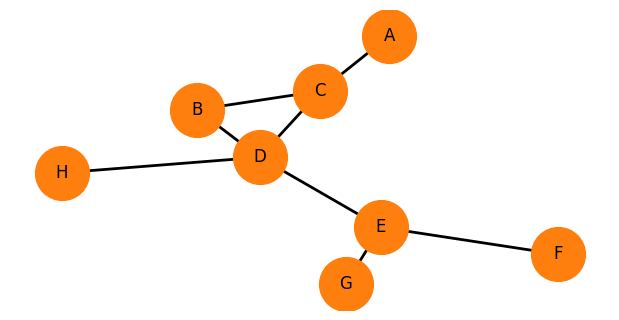


Jaccard coefficient values:
- ('A', 'B'): 0.50
- ('A', 'C'): 0.00
- ('A', 'D'): 0.25
- ('A', 'E'): 0.00
- ('A', 'F'): 0.00
- ('A', 'G'): 0.00
- ('A', 'H'): 0.00
- ('B', 'D'): 0.20
- ('B', 'E'): 0.25
- ('B', 'F'): 0.00
- ('B', 'G'): 0.00
- ('B', 'H'): 0.50
- ('C', 'B'): 0.25
- ('C', 'D'): 0.17
- ('C', 'E'): 0.20
- ('C', 'F'): 0.00
- ('C', 'G'): 0.00
- ('C', 'H'): 0.33
- ('D', 'E'): 0.00
- ('D', 'F'): 0.25
- ('D', 'G'): 0.25
- ('D', 'H'): 0.00
- ('E', 'F'): 0.00
- ('E', 'G'): 0.00
- ('E', 'H'): 0.33
- ('F', 'G'): 1.00
- ('H', 'F'): 0.00
- ('H', 'G'): 0.00


In [54]:
features_example(jaccard_coefficient, seed=42)

## Adamic-Adar index

\begin{equation}
    \text{adamic-adar}(u, v) = \sum_{w\in \Gamma(u)\cap\Gamma(v) } \frac{1}{\ln\left\vert \Gamma(w) \right\vert}
\end{equation}

In [55]:
list(G.neighbors("C")), list(G.neighbors("H")), list(G.neighbors("D"))

(['A', 'B', 'D'], ['D'], ['B', 'C', 'E', 'H'])

\begin{equation}
    \Gamma(C)\cap\Gamma(H)
    =
    \left\lbrace A, B, D  \right\rbrace
    \cap
    \left\lbrace D  \right\rbrace = \left\lbrace D  \right\rbrace
\end{equation}

\begin{equation}
    \Gamma(D)
    =
    \left\vert \left\lbrace B, C, E, H \right\rbrace \right\vert = 4
\end{equation}

\begin{equation}
    \text{adamic_adar}(C, H)
    =
    \frac{1}{\ln\left\vert \Gamma(w) \right\vert}
    =
    \frac{1}{\ln\left( 4 \right)}
\end{equation}

In [56]:
1/np.log(4)

0.7213475204444817

In [57]:
def adamic_adar_index(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    out = {}
    for item in nx.adamic_adar_index(G, itertools.combinations(G.nodes, 2)):
        out[(item[:2])] = item[2]

    return out

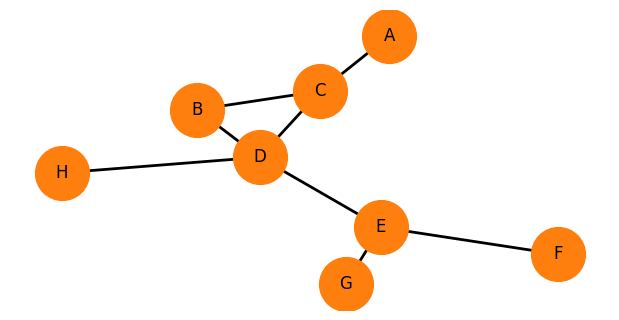


Adamic adar index values:
- ('A', 'B'): 0.91
- ('A', 'C'): 0.00
- ('A', 'D'): 0.91
- ('A', 'E'): 0.00
- ('A', 'F'): 0.00
- ('A', 'G'): 0.00
- ('A', 'H'): 0.00
- ('B', 'D'): 0.91
- ('B', 'E'): 0.72
- ('B', 'F'): 0.00
- ('B', 'G'): 0.00
- ('B', 'H'): 0.72
- ('C', 'B'): 0.72
- ('C', 'D'): 1.44
- ('C', 'E'): 0.72
- ('C', 'F'): 0.00
- ('C', 'G'): 0.00
- ('C', 'H'): 0.72
- ('D', 'E'): 0.00
- ('D', 'F'): 0.91
- ('D', 'G'): 0.91
- ('D', 'H'): 0.00
- ('E', 'F'): 0.00
- ('E', 'G'): 0.00
- ('E', 'H'): 0.72
- ('F', 'G'): 0.91
- ('H', 'F'): 0.00
- ('H', 'G'): 0.00


In [58]:
features_example(adamic_adar_index, seed=42)

# Global Neighborhood Overlap

From the eigenvector centrality definition we can obtain Katz centrality

\begin{equation}
    \lambda x = A^{T}x
    \quad \rightarrow \quad
    x = \frac{1}{\lambda} A^{T} x
    \quad \xrightarrow{\alpha, \beta} \quad
    x = \alpha A^{T} x + \beta I
\end{equation}

we solve it for $x$ and letting $\beta=1$ we obtain **Katz centrality**

\begin{equation}
    x = \beta(1 - \alpha A^{T})^{-1}I
    \quad \xrightarrow{\beta=1} \quad
    x = (1 - \alpha A^{T})^{-1}I
\end{equation}



In [59]:
def get_katz_index_matrix(G: nx.Graph, beta: float) -> np.ndarray:
    A = nx.adjacency_matrix(G).todense()
    X = beta * A
    max_eigval = np.linalg.eigvals(X).max()
    if max_eigval >= 1.0:
        raise ValueError(
            "to apply the geometric series of matrices, the maximum eigenvalue of beta * A must be < 1, got "
            f"{max_eigval}"
        )

    I = np.eye(X.shape[0])
    S = np.linalg.inv(I - X) - I
    return S


def katz_index_beta_03(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    S = get_katz_index_matrix(G, 0.3)
    nodes = list(G.nodes)
    ki = {}
    for node_pair in itertools.combinations(G.nodes, 2):
        row_idx = nodes.index(node_pair[0])
        col_idx = nodes.index(node_pair[1])
        ki[node_pair] = S[row_idx, col_idx]

    return ki


katz_index_beta_03.__name__ = "katz_index_(beta=0.3)"

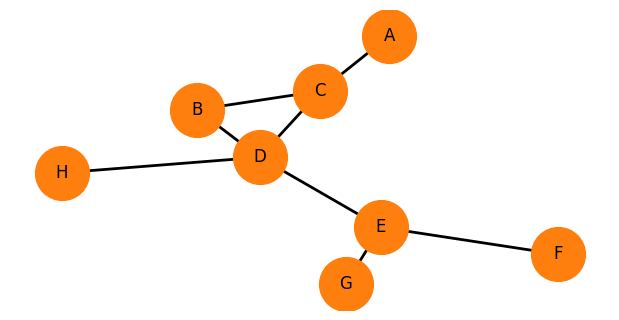


Katz index (beta=0.3) values:
- ('A', 'B'): 0.23
- ('A', 'C'): 0.50
- ('A', 'D'): 0.27
- ('A', 'E'): 0.10
- ('A', 'F'): 0.03
- ('A', 'G'): 0.03
- ('A', 'H'): 0.08
- ('B', 'D'): 0.84
- ('B', 'E'): 0.31
- ('B', 'F'): 0.09
- ('B', 'G'): 0.09
- ('B', 'H'): 0.25
- ('C', 'B'): 0.77
- ('C', 'D'): 0.91
- ('C', 'E'): 0.33
- ('C', 'F'): 0.10
- ('C', 'G'): 0.10
- ('C', 'H'): 0.27
- ('D', 'E'): 0.70
- ('D', 'F'): 0.21
- ('D', 'G'): 0.21
- ('D', 'H'): 0.57
- ('E', 'F'): 0.44
- ('E', 'G'): 0.44
- ('E', 'H'): 0.21
- ('F', 'G'): 0.13
- ('H', 'F'): 0.06
- ('H', 'G'): 0.06


In [60]:
features_example(katz_index_beta_03, seed=42)


*   Eigenvector centrality: $x = \lambda_{1}^{-1}A^{T}x$ where $\lambda_{1}$ is the largest eigenvalue
*   Katz centrality: $x = (1 - \alpha A^{T})^{-1}I$ where it is recommended to choose $\alpha$ below $\frac{1}{\lambda_{1}}$
*   Page Rank centrality: $x = \beta D(D - \alpha A^{T})^{-1}I$ where Google chose $\beta = (1-\alpha)/n$ and $\alpha=0.85$


# Graph-Level Features: Overview

Let's explore how an object recognition task can be formulated as a graph classification problem and solved using graph kernels.

> The following part is an adaptation of a [tutorial](https://github.com/ysig/GraKeL/blob/master/tutorials/digit_classification/digit_classification.ipynb) from the [GraKeL](https://ysig.github.io/GraKeL/0.1a8/) library

In [61]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
collections.Hashable = collections.abc.Hashable

In [62]:
rm -rf /Users/kamil-sabbagh/Desktop/TA/Data-Knowledge-Representation/.conda/lib/python3.9/site-packages/numpy*

In [63]:
pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp39-cp39-macosx_11_0_arm64.whl (13.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install grakel

Note: you may need to restart the kernel to use updated packages.


In [65]:
import grakel
from grakel.kernels import GraphletSampling, WeisfeilerLehman

In [66]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

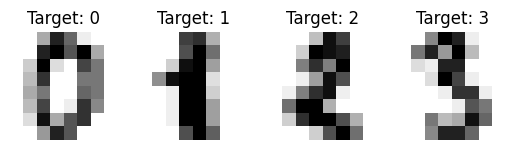

In [67]:
digits = load_digits()
images = digits.images
y = digits.target

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title(f"Target: {y[i]}")
    plt.axis("off")

In [68]:
def images_to_graphs(images: np.ndarray) -> List[grakel.Graph]:
    num_images, height, width = images.shape
    graphs = []
    edges = []
    edge_labels = {}
    for row_idx in range(height):
        for col_idx in range(width):
            if col_idx < width - 1:
                edge = (row_idx * height + col_idx, row_idx * height + col_idx + 1)
                edges.append(edge)
                edge_labels[edge] = 1

            if row_idx < height - 1:
                edge = (row_idx * height + col_idx, (row_idx + 1) * height + col_idx)
                edges.append(edge)
                edge_labels[edge] = 2

    for image_idx in range(num_images):
        node_labels = dict()
        for row_idx in range(height):
            for col_idx in range(width):
                node_labels[row_idx * height + col_idx] = int(images[image_idx, row_idx, col_idx] / 4)

        graphs.append(grakel.Graph(edges, node_labels=node_labels, edge_labels=edge_labels))

    return 

In [76]:
graphs = images_to_graphs(images)

In [77]:
index = 1
graphs[index].node_labels # intensity

{0: 0,
 1: 0,
 2: 0,
 3: 3,
 4: 3,
 5: 1,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 2,
 12: 4,
 13: 2,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 3,
 20: 4,
 21: 1,
 22: 0,
 23: 0,
 24: 0,
 25: 1,
 26: 3,
 27: 4,
 28: 4,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 4,
 36: 4,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 4,
 44: 4,
 45: 1,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 4,
 52: 4,
 53: 1,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 2,
 60: 4,
 61: 2,
 62: 0,
 63: 0}

In [78]:
graphs[index].edge_labels # 1 horizontal edge, 2 vertical edge

{(0, 1): 1,
 (0, 8): 2,
 (1, 2): 1,
 (1, 9): 2,
 (2, 3): 1,
 (2, 10): 2,
 (3, 4): 1,
 (3, 11): 2,
 (4, 5): 1,
 (4, 12): 2,
 (5, 6): 1,
 (5, 13): 2,
 (6, 7): 1,
 (6, 14): 2,
 (7, 15): 2,
 (8, 9): 1,
 (8, 16): 2,
 (9, 10): 1,
 (9, 17): 2,
 (10, 11): 1,
 (10, 18): 2,
 (11, 12): 1,
 (11, 19): 2,
 (12, 13): 1,
 (12, 20): 2,
 (13, 14): 1,
 (13, 21): 2,
 (14, 15): 1,
 (14, 22): 2,
 (15, 23): 2,
 (16, 17): 1,
 (16, 24): 2,
 (17, 18): 1,
 (17, 25): 2,
 (18, 19): 1,
 (18, 26): 2,
 (19, 20): 1,
 (19, 27): 2,
 (20, 21): 1,
 (20, 28): 2,
 (21, 22): 1,
 (21, 29): 2,
 (22, 23): 1,
 (22, 30): 2,
 (23, 31): 2,
 (24, 25): 1,
 (24, 32): 2,
 (25, 26): 1,
 (25, 33): 2,
 (26, 27): 1,
 (26, 34): 2,
 (27, 28): 1,
 (27, 35): 2,
 (28, 29): 1,
 (28, 36): 2,
 (29, 30): 1,
 (29, 37): 2,
 (30, 31): 1,
 (30, 38): 2,
 (31, 39): 2,
 (32, 33): 1,
 (32, 40): 2,
 (33, 34): 1,
 (33, 41): 2,
 (34, 35): 1,
 (34, 42): 2,
 (35, 36): 1,
 (35, 43): 2,
 (36, 37): 1,
 (36, 44): 2,
 (37, 38): 1,
 (37, 45): 2,
 (38, 39): 1,
 (38, 4

In [79]:
node_colors = {0: "white", 1: "yellow", 2: "pink", 3: "orange", 4:"red"}
edge_colors = {1: "blue", 2:"black"}

In [81]:
N = nx.Graph()
for pair, edge_label in graphs[index].edge_labels.items():
    N.add_edge(pair[0], pair[1])

In [82]:
fnodes = [node_colors[v] for k, v in graphs[index].node_labels.items()]
fedges = [edge_colors[v] for k, v in graphs[index].edge_labels.items()]

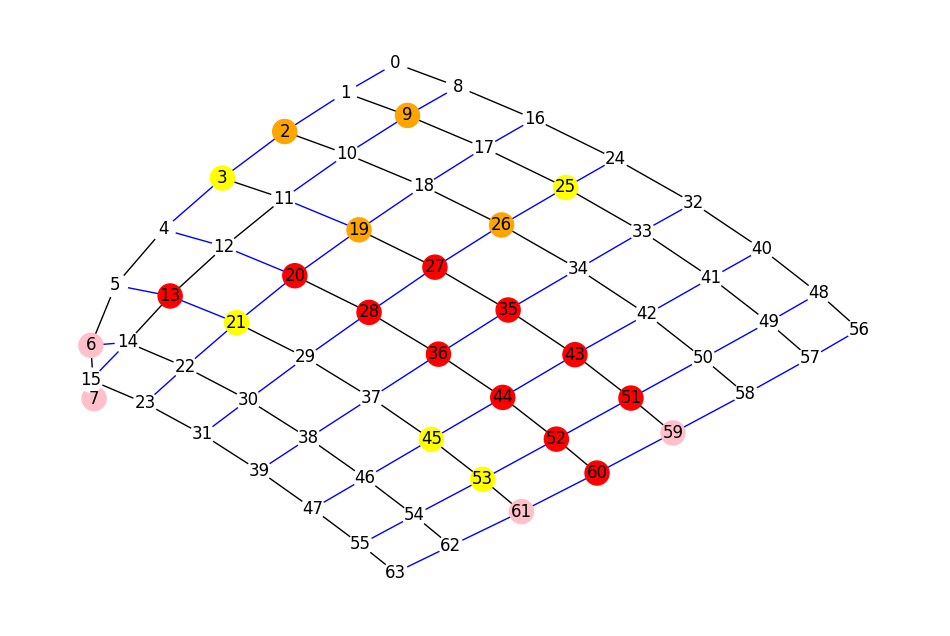

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
nx.draw(N, ax=ax, with_labels=True, node_color=fnodes, edge_color=fedges)
plt.show()

In [84]:
images[index]

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

In [85]:
graphs = images_to_graphs(images)

print("Splitting dataset into train/test (1000/100 instances)")
graphs_train, graphs_test = graphs[:1000], graphs[1000:1100]
y_train, y_test = y[:1000], y[1000:1100]

Splitting dataset into train/test (1000/100 instances)


**Graphs in the context with SVM**

Recall that for any ML-model, such as SVM we need


```
from sklearn import svm

# data points
X = [
    [0.1, -0.2, 0.9],
    [0.3, 0.4, -0.5],
    ...
]
# labels
y = [
    [0],
    [1],
    ...
]

# non-linear function
fX = [ (x[0] + x[1] + x[2], x[0]x[1]x[2], x[1]/(x[2] + x[3])) for x in X]

# fit and train
svm.SVC().fit(fX, y)
```

Here the computations involved in $\texttt{fX}$ under the user-defined function $f$ can be simplified by the use of kernels



*   A linear function leads to a linear kernel

\begin{equation}
    f(x) = x \in \mathbb{R}
    \quad \rightarrow \quad
    k(x_{i}, x_{j}) = x_{i}^{T}x_{j}
    \quad \rightarrow \quad
    \texttt{SVC(kernel='linear').fit(X,y)}
\end{equation}

*   Polynomial function leads to a polynomial-type kernel

\begin{equation}
    f(x) = (x_{1}, x_{2}, x_{1}x_{2}, x_{1}^{2}, x_{2}^{2}) \in \mathbb{R}^{5}
    \quad \rightarrow \quad
    k(x_{i}, x_{j}) = (1 + x_{i}^{T}x_{j})^{2}
    \quad \rightarrow \quad
    \texttt{SVC(kernel='poly').fit(X,y)}
\end{equation}

*   Radial functions lead to a radial-based kernel (RBF)

\begin{equation}
    f(x) = (e^{x_{1}}, e^{x_{2}}, \ldots) \in \mathbb{R}^{n}
    \quad \rightarrow \quad
    k(x_{i}, x_{j}) = e^{- \gamma \left\vert\left\vert x_{i} - x_{j} \right\vert\right\vert^{2}}
    \quad \rightarrow \quad
    \texttt{SVC(kernel='rbf', gamma=0.02).fit(X,y)}
\end{equation}






## Graphlet Kernel

In [86]:
start_time = time.perf_counter()

gk = GraphletSampling(k=3)
K_train = gk.fit_transform(graphs_train)
K_test = gk.transform(graphs_test)

clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)

y_pred = clf.predict(K_test)

print(f"Classification accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Duration: {time.perf_counter() - start_time:.2f} s")

Classification accuracy: 0.09
Duration: 9.68 s


## Weisfeiler-Lehman Kernel

In [87]:
start_time = time.perf_counter()

gk = WeisfeilerLehman(n_iter=5)
K_train = gk.fit_transform(graphs_train)
K_test = gk.transform(graphs_test)

clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)

y_pred = clf.predict(K_test)

print(f"Classification accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Duration: {time.perf_counter() - start_time:.2f} s")

Classification accuracy: 0.83
Duration: 0.74 s
